### Importing the Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM

np.random.seed(7)
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from pandas import option_context

#with option_context('display.max_colwidth', 100):

### Load the dataset 

In [2]:
Reviews_df = pd.read_csv('C:/Users/billu/OneDrive/Desktop/5661 project/Reviews - Copy.csv')
Reviews_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568165,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568166,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568167,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568168,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


## Exploratory Data Analysis

###  1. Size of the dataset

In [3]:
Reviews_df.shape

(568170, 10)

### 2.Converting the score values to positive or negative

#### Distribution of Ratings

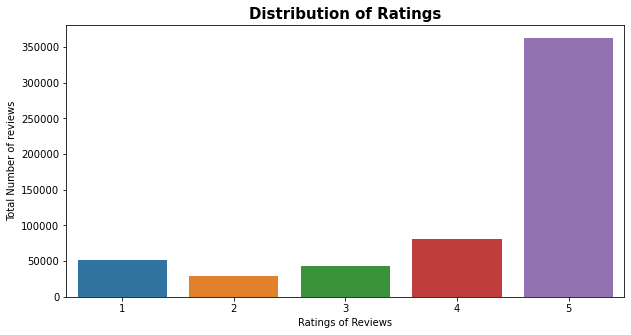

In [4]:
plt.figure(figsize=(10,5))
sns.countplot(Reviews_df['Score'])
plt.title("Distribution of Ratings", fontweight='bold', fontsize=15)
plt.xlabel("Ratings of Reviews")
plt.ylabel("Total Number of reviews")
plt.show();

On analysis,it shows that the dataset contains more positive reviews compared to negative reviews.
Therefore,will assign all data points above rating 3 as positive and below as negative rating for the reviews

In [5]:
#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
Reviews_df['Sentiment_Value'] = Reviews_df['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')


#Creating the new column which stores "Positive" as 1 and "Negative " as 0
Reviews_df['Target'] = Reviews_df['Sentiment_Value'].apply(lambda x : 1 if x == 'Positive' else 0)


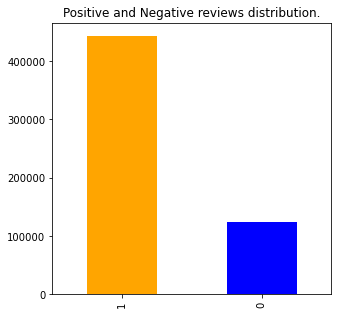

In [6]:
# Distribution of Postive and Negative reviews in a bar graph
Reviews_df["Target"].value_counts().plot(kind='bar',color=['orange','blue'],title='Positive and Negative reviews distribution.',figsize=(5,5))

 From the graph,it depicts that its an imbalanced dataset for classification.Therefore we need to choose AUC ROC for the accuracy as metric

In [7]:
#Total datapoints from the loaded dataset.
print("Number of independent variables in our data", Reviews_df.shape[0])
print("Number of dependent variables in our data", Reviews_df.shape[1])


Number of independent variables in our data 568170
Number of dependent variables in our data 12


### 3. Handle Missing values

In [8]:
Reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568170 entries, 0 to 568169
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568170 non-null  int64 
 1   ProductId               568170 non-null  object
 2   UserId                  568170 non-null  object
 3   ProfileName             568154 non-null  object
 4   HelpfulnessNumerator    568170 non-null  int64 
 5   HelpfulnessDenominator  568170 non-null  int64 
 6   Score                   568170 non-null  int64 
 7   Time                    568170 non-null  int64 
 8   Summary                 568143 non-null  object
 9   Text                    568170 non-null  object
 10  Sentiment_Value         568170 non-null  object
 11  Target                  568170 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 52.0+ MB


From the above result,it shows that the dataset don't have any null values.

 ### 4. Data Cleaning: Deduplication

* 1.The dataset contains many duplicate entries of reviews.So to overcome the unbaised results we are deduplicating the rows 
based  on UserId','ProfileName','Time' and sorting the dataset based on productId before deduplication to reduce the redundancy
* 2.The dataset contains the entries such that values in HelpfulnessNumerator is higher than the values in HelpfulnessDenominator as its practically not possible

In [9]:
#Sorting data according to ProductId in ascending order
df_sa=Reviews_df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Dropping the duplicates 
df_sa=df_sa.drop_duplicates(subset=['UserId','ProfileName','Time'],keep='first')
df_sa.tail(3)
#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
df_sa=df_sa[df_sa.HelpfulnessNumerator <= df_sa.HelpfulnessDenominator]

### Analysis of Dataset after datacleaning

In [10]:
#Calculating the remaining data after datacleaning
print("\npercentage of remaining data")
retained_per = (df_sa['Sentiment_Value'].size*1.0)/(Reviews_df['Sentiment_Value'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

print('------------------------------------------------------------------------------------------\n')
# Size of Data Set after removing duplicate values
print('New data set size-',df_sa.shape)
print("\n\nThe shape of the dataset after deduplication : {}".format(df_sa.shape))
print("The number of positive and negative reviews after the deduplication.")
print(df_sa["Sentiment_Value"].value_counts())


percentage of remaining data
Percentage of redundant data removed : 37.908900505130504
Percentage of original data retained : 62.091099494869496
------------------------------------------------------------------------------------------

New data set size- (352783, 12)


The shape of the dataset after deduplication : (352783, 12)
The number of positive and negative reviews after the deduplication.
Positive    273844
Negative     78939
Name: Sentiment_Value, dtype: int64


From the above results,the positive reviews are larger in number when compared to negative reviews,
So to maintain the balance,we are dropping the 170k positive reviews for easy computation and processing of data

In [11]:
#Data set sorting based on sentiment polarity and deleting positive values to balance Dataset
df_sort=df_sa.sort_values(by='Sentiment_Value')
df_dropped_last_n = df_sort.iloc[:-170000]
#df_dropped_last_n

#Display information about the dataset after the removal of postive data.
print("\nThe shape of the data matrix of balanced data".format(df_dropped_last_n.shape))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(df_dropped_last_n["Sentiment_Value"].value_counts())


The shape of the data matrix of balanced data
The number of positive and negative reviews after the removal of duplicate data.
Positive    103844
Negative     78939
Name: Sentiment_Value, dtype: int64


Now,we can see that dataset is comparatively balance and also overcomes the baised results

Text(0, 0.5, 'Reveiw classification')

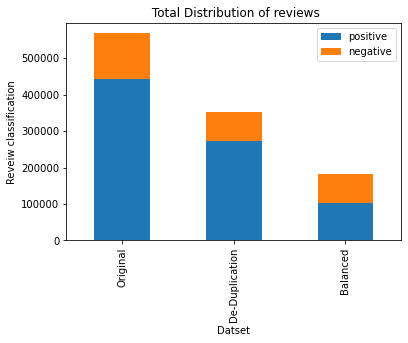

In [12]:
pos_1=Reviews_df["Sentiment_Value"].value_counts().get(key ='Positive')
pos_2=df_sa["Sentiment_Value"].value_counts().get(key ='Positive')
pos_3=df_dropped_last_n["Sentiment_Value"].value_counts().get(key ='Positive')
neg_1=Reviews_df["Sentiment_Value"].value_counts().get(key ='Negative')
neg_2=df_sa["Sentiment_Value"].value_counts().get(key ='Negative')
neg_3=df_dropped_last_n["Sentiment_Value"].value_counts().get(key ='Negative')

plotdata = pd.DataFrame({
    "positive":[pos_1, pos_2,pos_3],
    "negative":[neg_1, neg_2,neg_3],
 }, 
    index=["Original", "De-Duplication" ,"Balanced"]
)
plotdata.head()

plotdata.plot(kind='bar', stacked=True)

plt.title(" Total Distribution of reviews")
plt.xlabel("Datset")
plt.ylabel("Reveiw classification")

From the above graph,we are analysis the three stages of data distribution of positive and negative reviews 
after deduplication and dropping the rows.

## Data Preprocessing

In [13]:
def data_preprocess(sentence):
    #Remove words with numbers 
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    #Remove clean html tags from a sentence
    pattern = re.compile('<.*?>')
    sentence = re.sub(pattern,' ',sentence)
    #Remove words having three consecutive repeating characters.
    sentence  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    #Remove URL from sentences.
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    #Keep only words containing letters A-Z and a-z and remove all punctuations, special characters etc
    sentence  = re.sub('[^a-zA-Z]',' ',sentence)
    return (sentence)

### Stemming and Removal of stopwords

Here,we are defining custom stopwords which includes no,nor,not keywords so that classifier can learn and 
predict the sentiment of the review


In [14]:
#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
#print("default_stopwords:",default_stopwords)
remove_not = set(['no', 'nor', 'not'])
#print("--------------------------------------------------------------------------------------------------------------------")
defined_stopwords = default_stopwords - remove_not
print("defined_stopwords:\n",defined_stopwords)

defined_stopwords:
 {'or', 'him', 'through', 'is', 'been', 'now', 're', 'out', "wasn't", 'their', 'that', 'below', 'doing', 'while', 'so', "won't", 'here', 'shan', 'itself', 'was', 'with', 'further', 'were', 'as', "shan't", 'both', 'than', 'my', 'what', 'couldn', 'she', 'ourselves', 'it', 'for', 'who', 'then', 'and', 'if', 'wouldn', "that'll", "you're", 'hers', 'before', "mightn't", 'other', 'down', 'how', 'some', 'by', 'such', 'hasn', 'mustn', 'there', 'under', 'should', 'at', 'myself', 'have', 'which', 'll', 'hadn', 'ma', "mustn't", 'the', 'haven', "couldn't", "aren't", "haven't", 'to', 'didn', 'into', 'until', 'own', 'all', 'd', 'himself', 'after', 'won', 'you', 'weren', 'too', 'themselves', 'am', 'because', "should've", "it's", 'them', 'his', 'these', 'against', 'but', 'will', 'between', "weren't", 'just', 'when', 'few', 'an', 'shouldn', 'from', 'do', 's', 'up', 'those', 'ours', 'very', "isn't", 've', 'why', 'yourselves', 'only', 'off', 'doesn', 'more', 'theirs', 'has', 'needn', 'o


### Convert all the words to lower case and replace the contraction words

To bulid good model,we are replacing the contraction words with meaning full word and 
converting all the characters to lowercase

In [15]:
import re

# Convert all the words to lower case and replace the contraction words
def replace_words(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                          
    #Converting 123000000 to 123m
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    #converting 123000 to 123k
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

### Distribution of Stemmed word length

In [16]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
total_words = []
#List all the processed reviews
preprocessed_reviews = [] 
#list all the relevant words from Positive reviews
all_positive_words=[] 
#list all the relevant words from Negative reviews
all_negative_words=[] 
 
#Iterate through the list of reviews and check if a given review belongs to the positive or negative 
count=0  
string=' '    
stemed_word=' '

for review in tqdm(df_dropped_last_n['Text'].values):
    filtered_sentence=[]
    review = data_preprocess(review)
  
 
    
    for cleaned_words in review.split():   
        if((cleaned_words not in defined_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)
           
            filtered_sentence.append(stemed_word)
             #List of all the relevant words from Positive reviews
            if (df_dropped_last_n['Sentiment_Value'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word)
            #List of all the relevant words from Negative reviews
            if(df_dropped_last_n['Sentiment_Value'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) 
        else:
            continue
    
    review = " ".join(filtered_sentence) #Final string of cleaned words 
    #print("After review:",review)
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    #print("preprocessed_reviews:",preprocessed_reviews)
    count+=1

total_words = list(set(total_words))
#print("total_words:",total_words)   
#print(count(total_words))
#list all the length of words
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)


#print("------------------------------------------------------------------------------------------------------------------")
#print("length_word:",dist)


100%|████████████████████████████████████████████████████████████████████████| 49783/49783 [00:00<00:00, 327024.84it/s]


Text(0, 0.5, 'Number of Words')

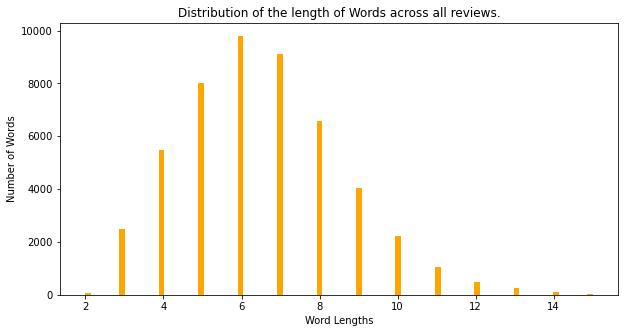

In [17]:
# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(10,5))
plt.hist(dist, color = 'orange', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

From the graph,We can see that Words which has length range between 2 to 15 are more and words which has length greater than 15 are few so will consider the words whose length is greater than 2 and less than 16.

### Visualization of Positive words and negative words from the reviews after data processing using word cloud

#### Positive review WordCloud

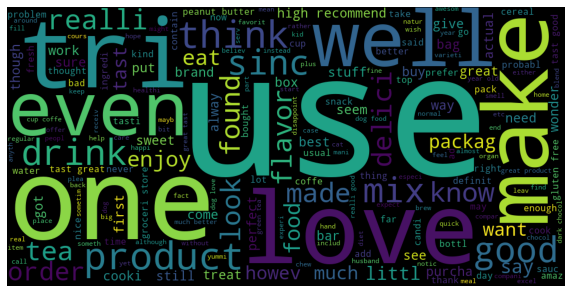

In [18]:
from wordcloud import WordCloud
#plotting all the posituve words
positive_string=(" ").join(all_positive_words)
wordcloud = WordCloud(width = 1000, height = 500).generate(positive_string)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

#### Negative review WordCloud

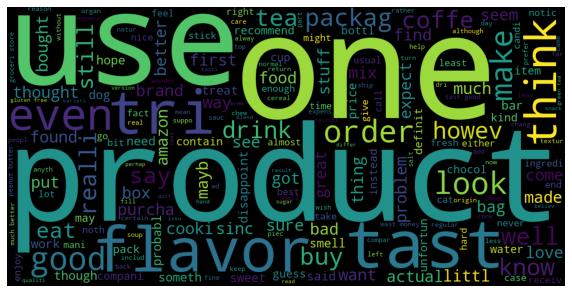

In [19]:
from wordcloud import WordCloud
#plotting all the negative words
negative_string=(" ").join(all_negative_words)
wordcloud = WordCloud(width = 1000, height = 500).generate(negative_string)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

### Processing review Texts

In [20]:
  #Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
df_dropped_last_n['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))
df_dropped_last_n.head(3)

The length of the data corpus is : 182783


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_Value,Target,CleanedText
242250,242387,B001EO5S76,A2BGX4BF5NWHQA,Aunt Lovina,4,6,3,1165363200,SMASHED TINS,"The tea is delicious, but Amazon sent it in th...",Negative,0,the tea delici amazon sent box sever bar soap ...
85484,85521,B001A1VDR2,A1LM4CPAEKDT2A,"Reba ""matriarch""",0,4,1,1286582400,deficient product description,I may have purchased the product if there had ...,Negative,0,may purchas product descript kind chees what k...
85483,85520,B001A1VDR2,A1LD2S14L3AC1G,Rick in CT,0,0,1,1306108800,Vague description = do not buy,The previous reviewer was quite right. When th...,Negative,0,the previous review quit right when price drop...


In [21]:
#Calculating the percentage of Positive and negative words
value_count=df_dropped_last_n['Target'].value_counts()
value_count
print("{}% data having positive reviews".format(round(value_count[1]/df_dropped_last_n.shape[0]*100,2)))
print("{}% data having negative reviews".format(round(value_count[0]/df_dropped_last_n.shape[0]*100,2)))#

56.81% data having positive reviews
43.19% data having negative reviews


### Split the dataset

To train and test model,we are splitting the dataset to 70% for training and 30% for testing the dataset

In [22]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = df_dropped_last_n['CleanedText']
y = df_dropped_last_n['Target']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)


##  Feature Extraction: Bag of Words

 Word Embedding is a technique to convert words to vectors.The Bag of Words model is the simplest form of text representing a sentence as a a string of numbers.It considers a sparse vector

In [148]:
bow = CountVectorizer()
bow.fit(X_train)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()
print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (127948, 41582)
shape of X_test_bow is (54835, 41582)


In [24]:
#print(np.array(X_test_bow))

In [25]:
#  function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))
    #sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()

### 1.XGBOOST On BagOfWords Features

In [26]:
xg_best_est = XGBClassifier(n_estimators = 120,max_depth=15)
xg_best_est = xg_best_est.fit(X_train_bow,y_train)
y_predict = xg_best_est.predict(X_test_bow)
train_fpr_xg_bow, train_tpr_xg_bow, thresholds = roc_curve(y_train, xg_best_est.predict_proba(X_train_bow)[:,1])
test_fpr_xg_bow, test_tpr_xg_bow, thresholds = roc_curve(y_test, xg_best_est.predict_proba(X_test_bow)[:,1])


[11:51:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Performance Metric:ROC , AUC ,Confusion Matrix

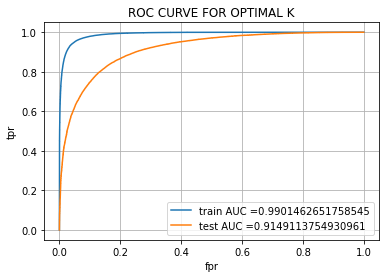

Area under train roc 0.9901462651758545
Area under test roc 0.9149113754930961


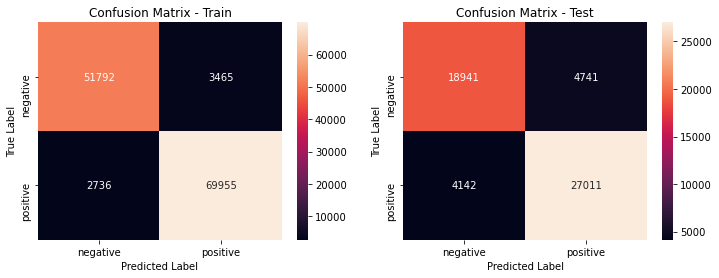

In [27]:
plt.grid(True)
plt.plot(train_fpr_xg_bow, train_tpr_xg_bow, label="train AUC ="+str(auc(train_fpr_xg_bow, train_tpr_xg_bow)))
plt.plot(test_fpr_xg_bow, test_tpr_xg_bow, label="test AUC ="+str(auc(test_fpr_xg_bow, test_tpr_xg_bow)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr_xg_bow, train_tpr_xg_bow)))
print('Area under test roc {}'.format(auc(test_fpr_xg_bow, test_tpr_xg_bow)))
plot_confusion_matrixes(xg_best_est,X_train_bow,y_train,X_test_bow,y_test)

From the graph,we can analyse that Xgboosting with the Bag of words model is slightly overfitting.So we tried training and testing on various classifiers

# Top 20 Features

In [28]:
top_words= xg_best_est.feature_importances_
features = bow_features
top_words = pd.DataFrame(top_words,columns=['coef'],index=features)
top = top_words.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))

Top 20 features are: 
                 coef
disappoint  0.007492
threw       0.006682
return      0.006453
delici      0.006170
aw          0.005742
perfect     0.005430
yummi       0.004752
worst       0.004634
disgust     0.004552
excel       0.004505
hook        0.004328
horribl     0.004154
mislead     0.004059
terribl     0.004009
bewar       0.003657
amaz        0.003629
yum         0.003558
awesom      0.003339
rip         0.003320
stale       0.003312


### Performace Metric:Cross-Validation

In [29]:
from sklearn.model_selection import cross_val_score
accuracy= cross_val_score(xg_best_est, X_test_bow, y_test, cv=10, scoring='accuracy')
accuracy.mean()

[11:53:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:53:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.8289416741062787

### To print false predicted values

In [30]:
results = pd.DataFrame()
results['actual'] = y_test 
results['prediction'] = y_predict
print(results[results['actual']!=results['prediction']])


        actual  prediction
5270         0           1
319650       0           1
139187       0           1
208404       0           1
168053       1           0
...        ...         ...
110303       1           0
235276       1           0
190390       1           0
559714       1           0
84805        1           0

[8883 rows x 2 columns]


## 2.SVM Classifier on Bag of Words feature

In [150]:
from sklearn.linear_model import SGDClassifier
svm_opt = SGDClassifier(alpha=0.001) 
svm_opt.fit(X_train_bow,y_train)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_bow,y_train)
y_predict =best_est.predict(X_test_bow)
train_fpr_svm_op, train_tpr_svm_op, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_bow)[:,1])
test_fpr_svm_op, test_tpr_svm_op, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

### Performance Metric:ROC , AUC ,Confusion Matrix

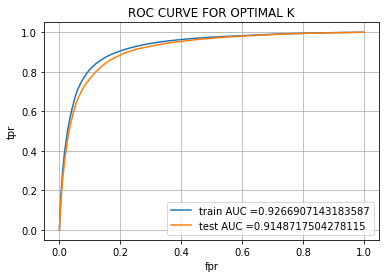

Area under train roc 0.9266907143183587
Area under test roc 0.9148717504278115


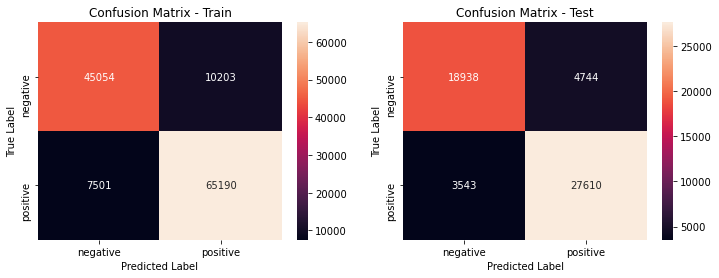

In [32]:

plt.grid(True)
plt.plot(train_fpr_svm_op, train_tpr_svm_op, label="train AUC ="+str(auc(train_fpr_svm_op, train_tpr_svm_op)))
plt.plot(test_fpr_svm_op, test_tpr_svm_op, label="test AUC ="+str(auc(test_fpr_svm_op, test_tpr_svm_op)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr_svm_op, train_tpr_svm_op)))
print('Area under test roc {}'.format(auc(test_fpr_svm_op, test_tpr_svm_op)))
plot_confusion_matrixes(svm_opt,X_train_bow,y_train,X_test_bow,y_test)

From the graph,we can analyse that SVM with the Bag of words model performs better than xgboosting but still it is slightly overfitting.

### Performace Metric:Cross-Validation

In [33]:
from sklearn.model_selection import cross_val_score
accuracy= cross_val_score(svm_opt, X_test_bow, y_test, cv=10, scoring='accuracy')
accuracy.mean()

0.8437131685989703

## Feature Extraction:TF-IDF Vectorization

TF-IDF also gives larger values for less frequent words and is high when both IDF and TF values are high 
i.e the word is rare in all the documents combined but frequent in a single document.It considers as sparse vectors

In [34]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
tfidf_features = vectorizer.get_feature_names()
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## 3. Navie Bayes on TFIDF Vectorization

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
optimal_alpha = 0.1
naive_opt = MultinomialNB(alpha=optimal_alpha)
naive_opt = naive_opt.fit(X_train_tfidf,y_train)
train_fpr_naive_opt, train_tpr_naive_opt, thresholds = roc_curve(y_train, naive_opt.predict_proba(X_train_tfidf)[:,1])
test_fpr_naive_opt, test_tpr_naive_opt, thresholds = roc_curve(y_test, naive_opt.predict_proba(X_test_tfidf)[:,1])

### Performance Metric:ROC , AUC ,Confusion Matrix

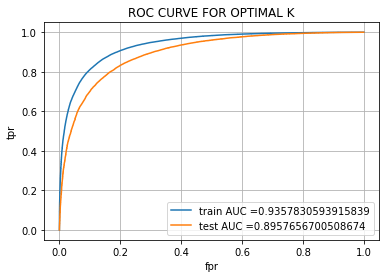

Area under train roc 0.9357830593915839
Area under test roc 0.8957656700508674


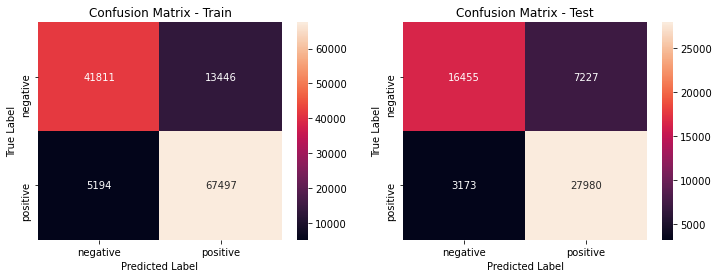

In [36]:
plt.grid(True)
plt.plot(train_fpr_naive_opt, train_tpr_naive_opt, label="train AUC ="+str(auc(train_fpr_naive_opt, train_tpr_naive_opt)))
plt.plot(test_fpr_naive_opt, test_tpr_naive_opt, label="test AUC ="+str(auc(test_fpr_naive_opt, test_tpr_naive_opt)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr_naive_opt, train_tpr_naive_opt)))
print('Area under test roc {}'.format(auc(test_fpr_naive_opt, test_tpr_naive_opt)))

plot_confusion_matrixes(naive_opt,X_train_tfidf,y_train,X_test_tfidf,y_test)

From the AUC ROC graph,the naive bayes model with tfidf vectorization also a slighlty overfitting  model  but performs better than Bag of words feature extraction

### Performace Metric:Cross-Validation

In [37]:
from sklearn.model_selection import cross_val_score
accuracy= cross_val_score(naive_opt, X_test_tfidf, y_test, cv=10, scoring='accuracy')
accuracy.mean()

0.8043585650920496

## Feature Extraction: Word2Vec 

Its is the most powerful technique which takes sematic meaning into consideration.It is one of the type of NLP 
which can detect synonyms and suggect additional words for partial sentences after training.It considers a dense vectors

In [145]:
preprocessed_reviews = X_train.values
train_sentence = [rev.split() for rev in preprocessed_reviews]
# min_count = 5 considers only words that occured atleast 5 times
# size = length of vector
w2v_model_train = Word2Vec(train_sentence,min_count=5,vector_size=50, workers=4)
w2v_words = list(w2v_model_train.wv.key_to_index)

### Average Word2Vec

In [146]:
#convert Train dataset to vectors
train_reviews = X_train.values
train_sentence = [rev.split() for rev in train_reviews]

sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

#convert Test dataset to vectors
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]

sent_vectors_test = []
for sent in tqdm(test_sentence):
    count = 0
    sent_vec = np.zeros(50)
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            count += 1
            
    if count != 0:
        sent_vec /= count
    sent_vectors_test.append(sent_vec)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|████████████████████████████████████████████████████████████████████████| 127948/127948 [01:47<00:00, 1185.96it/s]


127948
50


100%|██████████████████████████████████████████████████████████████████████████| 54835/54835 [00:45<00:00, 1207.15it/s]

54835
50


In [147]:
X_train_avgw2v = np.array(sent_vectors_train)
X_test_avgw2v = np.array(sent_vectors_test)
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))

shape of X_train_avgw2v is (127948, 50)
shape of X_test_avgw2v is (54835, 50)


# SVM with Avgword2vec 

In [41]:
from sklearn.linear_model import SGDClassifier
svm_opt_w2v = SGDClassifier(alpha=0.001) 
svm_opt_w2v.fit(X_train_avgw2v,y_train)
best_est_w2v = CalibratedClassifierCV(base_estimator=svm_opt_w2v)
best_est_w2v = best_est_w2v.fit(X_train_avgw2v,y_train)
train_fpr_svm_w2v, train_tpr_svm_w2v, thresholds = roc_curve(y_train, best_est_w2v.predict_proba(X_train_avgw2v)[:,1])
test_fpr_svm_w2v, test_tpr_svm_w2v, thresholds = roc_curve(y_test, best_est_w2v.predict_proba(X_test_avgw2v)[:,1])

# Performance Metric:ROC , AUC ,Confusion Matrix

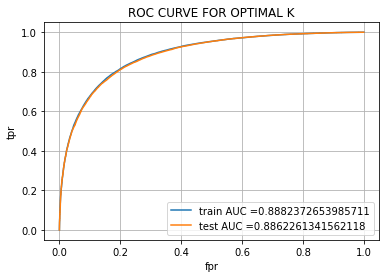

Area under train roc 0.8882372653985711
Area under test roc 0.8862261341562118


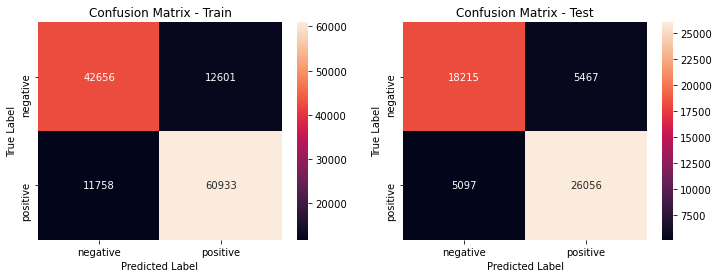

In [42]:

plt.grid(True)
plt.plot(train_fpr_svm_w2v, train_tpr_svm_w2v, label="train AUC ="+str(auc(train_fpr_svm_w2v, train_tpr_svm_w2v)))
plt.plot(test_fpr_svm_w2v, test_tpr_svm_w2v, label="test AUC ="+str(auc(test_fpr_svm_w2v, test_tpr_svm_w2v)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr_svm_w2v, train_tpr_svm_w2v)))
print('Area under test roc {}'.format(auc(test_fpr_svm_w2v, test_tpr_svm_w2v)))
plot_confusion_matrixes(svm_opt_w2v,X_train_avgw2v,y_train,X_test_avgw2v,y_test)

From the AUC ROC graph,the SVM model with avgword2vec vectorization produces slight overfitting  model and SVM classifier on Bag of words feature extraction performs equally good.

### Performace Metric:Cross-Validation

In [43]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
accuracy= cross_val_score(svm_opt_w2v, X_test_avgw2v, y_test, cv=10, scoring='accuracy')
accuracy.mean()

0.8051427673867092

## 4.Random Forest on Tfidf feature

In [44]:
best_est_rf = RandomForestClassifier(n_estimators = 120,max_depth=30)
best_est_rf = best_est.fit(X_train_tfidf,y_train)
train_fpr_est_rf, train_tpr_est_rf, thresholds = roc_curve(y_train, best_est_rf.predict_proba(X_train_tfidf)[:,1])
test_fpr_est_rf, test_tpr_est_rf, thresholds = roc_curve(y_test, best_est_rf.predict_proba(X_test_tfidf)[:,1])

### Performance Metric:ROC , AUC ,Confusion Matrix

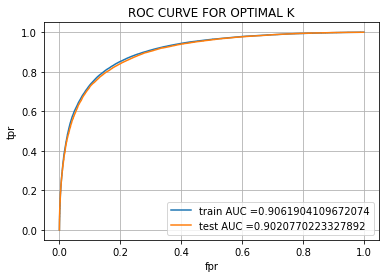

Area under train roc 0.9061904109672074
Area under test roc 0.9020770223327892


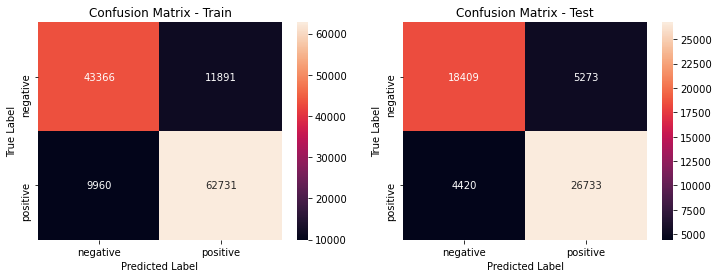

In [45]:
plt.grid(True)
plt.plot(train_fpr_est_rf, train_tpr_est_rf, label="train AUC ="+str(auc(train_fpr_est_rf, train_tpr_est_rf)))
plt.plot(test_fpr_est_rf, test_tpr_est_rf, label="test AUC ="+str(auc(test_fpr_est_rf, test_tpr_est_rf)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr_est_rf, train_tpr_est_rf)))
print('Area under test roc {}'.format(auc(test_fpr_est_rf, test_tpr_est_rf)))
plot_confusion_matrixes(best_est_rf,X_train_tfidf,y_train,X_test_tfidf,y_test)

From the AUC ROC graph,the Random Forest model with TF-idf vectorization produces good fit model and performs well 


### Performace Metric:Cross-Validation

In [46]:
from sklearn.model_selection import cross_val_score
accuracy= cross_val_score(best_est_rf, X_test_tfidf, y_test, cv=10, scoring='accuracy')
accuracy.mean()

0.8225040982717884

## Conclusion

In [47]:
from prettytable import PrettyTable
    
tb = PrettyTable()

tb.field_names = ["Vector","Algorithm","Train AUC", "Test AUC"]
tb.add_row(["bow","SVM",auc(train_fpr_svm_op, train_tpr_svm_op),auc(train_fpr_svm_op, train_tpr_svm_op)])
tb.add_row(["bow","xgboost",auc(train_fpr_xg_bow, train_tpr_xg_bow),auc(test_fpr_xg_bow, test_tpr_xg_bow)])
tb.add_row(["tfidf","Random_Forest",auc(train_fpr_est_rf, train_tpr_est_rf),auc(test_fpr_est_rf, test_tpr_est_rf)])
tb.add_row(["tfidf","NaiveBayes",auc(train_fpr_naive_opt, train_tpr_naive_opt), auc(test_fpr_naive_opt, test_tpr_naive_opt)])
tb.add_row(["Average_w2v","SVM",auc(train_fpr_svm_w2v, train_tpr_svm_w2v), auc(test_fpr_svm_w2v, test_tpr_svm_w2v)])
print(tb)

+-------------+---------------+--------------------+--------------------+
|    Vector   |   Algorithm   |     Train AUC      |      Test AUC      |
+-------------+---------------+--------------------+--------------------+
|     bow     |      SVM      | 0.9266907143183587 | 0.9266907143183587 |
|     bow     |    xgboost    | 0.9901462651758545 | 0.9149113754930961 |
|    tfidf    | Random_Forest | 0.9061904109672074 | 0.9020770223327892 |
|    tfidf    |   NaiveBayes  | 0.9357830593915839 | 0.8957656700508674 |
| Average_w2v |      SVM      | 0.8882372653985711 | 0.8862261341562118 |
+-------------+---------------+--------------------+--------------------+


After implementing several advanced machine learning classifier we can see that Random Forest on tfidf
and SVM on bag of word features gives a more generalized model.

### Responsibilty Of Team Member

In [48]:
tb = PrettyTable()

tb.field_names = ["Member","Feature Extraction","Algorithms", "Miscellaneous"]
tb.add_row(["Lakshmi Sindhuri Kampati ","TFIDF","Naive Bayes","EDA"])
tb.add_row(["Vijay Naregal ","Bag Of Words","Random Forest","Data visualization"])
tb.add_row(["Shravani Badadha","word2vec","XGBOOST,SVM","Data Preprocessing"])

print(tb)

+---------------------------+--------------------+---------------+--------------------+
|           Member          | Feature Extraction |   Algorithms  |   Miscellaneous    |
+---------------------------+--------------------+---------------+--------------------+
| Lakshmi Sindhuri Kampati  |       TFIDF        |  Naive Bayes  |        EDA         |
|       Vijay Naregal       |    Bag Of Words    | Random Forest | Data visualization |
|      Shravani Badadha     |      word2vec      |  XGBOOST,SVM  | Data Preprocessing |
+---------------------------+--------------------+---------------+--------------------+


## Random Forest_tfidf

In [178]:
review= 'product is satisfying'
print(review)
# vectorizing
review_vector = vectorizer.transform([review]) 
#prediction
print(best_est_rf.predict(review_vector))

product is satisfying
[0]


## Naive Bayes_tfidf

In [180]:
review= 'product is satisfying'
print(review)
# vectorizing
review_vector = vectorizer.transform([review]) 
#prediction
print(naive_opt.predict(review_vector))

product is satisfying
[1]


## Test the Xgboost classifier using BOW

In [182]:
review= 'product is not  good'
print(review)
# vectorizing
review_vector = bow.transform([review]) 
#prediction
print(xg_best_est.predict(review_vector))

product is not  good
[0]


### Test SVM Bag of words

In [184]:
review= 'food is not better'
print(review)
# vectorizing
review_vector = bow.transform([review]) 
#prediction
print(best_est.predict(review_vector))

food is not better
[0]
